# Guessing two tau values in double exponential lifetime simulations

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit

How many samples per run (samples=photons)

In [6]:
samples=200

Fitting function used later

In [15]:
def fitme(xx, amplitude, tau1, tau2):
    return amplitude*(np.exp(-xx/tau1)+np.exp(-xx/tau2))

Generate X and Y

In [7]:
def get_some_lifetime_data_old(copies, dim):
    Y=10.0*np.sort(np.random.uniform(size=[copies,2]))
    X=np.zeros(shape=[copies,dim])
    for s in range(0,copies):
        tau=(Y[s,0]*Y[s,1])/(Y[s,0]+Y[s,1])
        #tau=Y[s,0]
        X[s,:]=np.random.exponential(scale=tau, size=[1,dim])
    return (X,Y)

In [8]:
XX=np.linspace(0.1,100, num=10000)
def get_some_lifetime_data(copies, dim):
    Y=10.0*np.sort(np.random.uniform(size=[copies,2]))
    X=np.zeros(shape=[copies,dim])
    for s in range(0,copies):
        YY=np.exp(-XX/Y[s,0])+np.exp(-XX/Y[s,1])
        X[s,:]=np.random.choice(XX,p=YY/np.sum(YY), size=[1,dim])
    return (X,Y)
    
    
        

Setup tf

In [9]:
def original_network(x):
    xflat=tf.contrib.layers.flatten(x)
    layerA=tf.contrib.layers.fully_connected(xflat,10)
    layerB=tf.contrib.layers.fully_connected(layerA, 5)
    return tf.contrib.layers.fully_connected(layerB,2)

In [10]:
def new_network(x):
    xflat=tf.contrib.layers.flatten(x)
    layerA=tf.contrib.layers.fully_connected(xflat,200)
    layerB=tf.contrib.layers.fully_connected(layerA,50)
    layerC=tf.contrib.layers.fully_connected(layerB,10)
    layerD=tf.contrib.layers.fully_connected(layerC,5)
    return tf.contrib.layers.fully_connected(layerD,2)

Load network, calculate loss

In [11]:
x=tf.placeholder(dtype=tf.float32, shape=[None, samples])
y=tf.placeholder(dtype=tf.float32, shape=[None, 2])

logits=new_network(x)

#Setup loss calculation, start with squared error
#YF=tf.reshape(y, shape=[tf.shape(y)[0], 1])
diff=tf.subtract(logits, y)
LS=tf.multiply(diff,diff)
#Add them together
loss=tf.reduce_mean(LS)
train_op=tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


#correct_pred=tf.round(logits)
#accuracy=tf.reduce_mean(tf.abs(tf.subtract(correct_pred, Y)))

Train network

In [12]:
tf.set_random_seed(123456)
sess=tf.Session()

sess.run(tf.global_variables_initializer())

(X,Y)=get_some_lifetime_data(1000,samples)
results=0
for i in range(8000):
    if (i%100==0):
        (X,Y)=get_some_lifetime_data(1000,samples)    
    _,results, LN,losses=sess.run([train_op, logits, LS, loss], feed_dict={x:X, y:Y})
    if (i%300==0):
        print("Error rate: ", LN.shape)
        print("Real loss: ",losses)
        

Error rate:  (1000, 2)
Real loss:  31.6551
Error rate:  (1000, 2)
Real loss:  16.0001
Error rate:  (1000, 2)
Real loss:  11.5929
Error rate:  (1000, 2)
Real loss:  9.9125
Error rate:  (1000, 2)
Real loss:  3.04268
Error rate:  (1000, 2)
Real loss:  2.73281
Error rate:  (1000, 2)
Real loss:  2.81789
Error rate:  (1000, 2)
Real loss:  3.00369
Error rate:  (1000, 2)
Real loss:  2.66997
Error rate:  (1000, 2)
Real loss:  2.74193
Error rate:  (1000, 2)
Real loss:  2.91918
Error rate:  (1000, 2)
Real loss:  2.51379
Error rate:  (1000, 2)
Real loss:  2.71878
Error rate:  (1000, 2)
Real loss:  2.76
Error rate:  (1000, 2)
Real loss:  2.7468
Error rate:  (1000, 2)
Real loss:  2.90819
Error rate:  (1000, 2)
Real loss:  2.70309
Error rate:  (1000, 2)
Real loss:  2.8262
Error rate:  (1000, 2)
Real loss:  2.55627
Error rate:  (1000, 2)
Real loss:  2.55992
Error rate:  (1000, 2)
Real loss:  2.85616
Error rate:  (1000, 2)
Real loss:  2.69795
Error rate:  (1000, 2)
Real loss:  2.60747
Error rate:  (100

Test data on a new set, one run at a time

In [13]:
(X,Y)=get_some_lifetime_data(1000,samples)
results, LN,losses=sess.run([logits, LS, loss], feed_dict={x:X, y:Y})

[ 3.05078086  6.85500183]
[ 4.14753294  6.60957956]
5.91026552655
2.11120201655
[ 5.64791511  5.6485056 ]


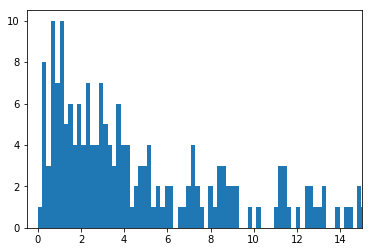

In [17]:
idx=np.random.randint(0,500)
thehist=plt.hist(X[idx,:], bins=np.linspace(0,16,num=80))
plt.xlim(-0.5,15)
print(Y[idx,:])
print(results[idx,:])
print(np.mean(X[idx,:]))
print(Y[idx,0]*Y[idx,1]/(Y[idx,0]+Y[idx,1]))

x_vals=[np.mean([thehist[1][i], thehist[1][i+1]]) for i in range(0,len(thehist[1])-1) ]
y_vals=thehist[0]   
popt, pc=curve_fit(fitme, x_vals, y_vals, bounds=(0.001, [100000,15,15]))
print(np.sort([popt[1], popt[2]]))

[1051.1761400697203, 3327.2459579163105]

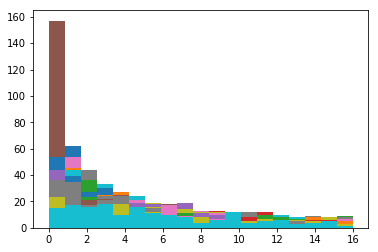

In [18]:
LSQ=np.zeros([500,2])
NN=np.zeros([500,2])
for j in range(0,200):
    thehist=plt.hist(X[j,:], bins=np.linspace(0,16,num=20))
    NN[j,:]=Y[j,:]-results[j,:]
    
    x_vals=[np.mean([thehist[1][i], thehist[1][i+1]]) for i in range(0,len(thehist[1])-1) ]
    y_vals=thehist[0]   
    popt, pc=curve_fit(fitme, x_vals, y_vals, bounds=(0.001, [100000,15,15]))
    S=np.sort([popt[1], popt[2]])
    LSQ[j,:]=Y[j,:]-S
[np.sum(np.square(NN)), np.sum(np.square(LSQ))]

In [142]:
xbins=np.linspace(0,16,200)
c,d=np.histogram(X[0,:], bins=xbins)
d[0:-1]+xbins[1]/2

array([  0.04020101,   0.12060302,   0.20100503,   0.28140704,
         0.36180905,   0.44221106,   0.52261307,   0.60301508,
         0.68341709,   0.7638191 ,   0.84422111,   0.92462312,
         1.00502513,   1.08542714,   1.16582915,   1.24623116,
         1.32663317,   1.40703518,   1.48743719,   1.5678392 ,
         1.64824121,   1.72864322,   1.80904523,   1.88944724,
         1.96984925,   2.05025126,   2.13065327,   2.21105528,
         2.29145729,   2.3718593 ,   2.45226131,   2.53266332,
         2.61306533,   2.69346734,   2.77386935,   2.85427136,
         2.93467337,   3.01507538,   3.09547739,   3.1758794 ,
         3.25628141,   3.33668342,   3.41708543,   3.49748744,
         3.57788945,   3.65829146,   3.73869347,   3.81909548,
         3.89949749,   3.9798995 ,   4.06030151,   4.14070352,
         4.22110553,   4.30150754,   4.38190955,   4.46231156,
         4.54271357,   4.62311558,   4.70351759,   4.7839196 ,
         4.86432161,   4.94472362,   5.02512563,   5.10

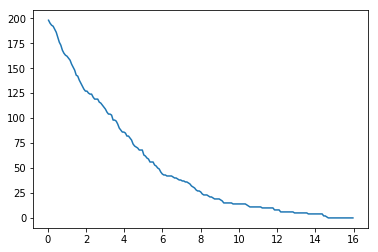

In [125]:
plt.plot(x_vals,np.sum(y_vals)-np.cumsum(y_vals))

In [126]:
popt, pc=curve_fit(fitme, x_vals, np.sum(y_vals)-np.cumsum(y_vals), bounds=(0.001, [100000,15,15]))
popt

array([ 105.02174317,    4.06085661,    4.06092945])

In [27]:
x_vals=[np.mean([thehist[1][i], thehist[1][i+1]]) for i in range(0,len(thehist[1])-1) ]
y_vals=thehist[0]    

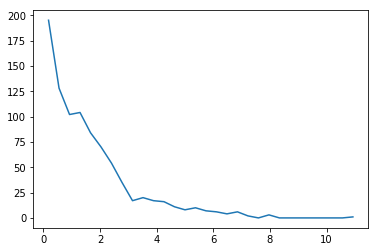

In [28]:
plt.plot(x_vals, y_vals)

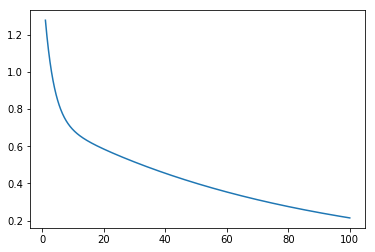

In [47]:
XX=np.linspace(1,100, num=1000)
YY=0.75*np.exp(-XX/3)+0.75*np.exp(-XX/80)
plt.plot(XX,YY)

(array([ 833.,  628.,  491.,  522.,  473.,  446.,  444.,  412.,  374.,
         363.,  338.,  341.,  311.,  323.,  299.,  296.,  299.,  283.,
         249.,  278.,  270.,  199.,  250.,  206.,  191.,  198.,  181.,
         164.,  169.,  169.]),
 array([   1. ,    4.3,    7.6,   10.9,   14.2,   17.5,   20.8,   24.1,
          27.4,   30.7,   34. ,   37.3,   40.6,   43.9,   47.2,   50.5,
          53.8,   57.1,   60.4,   63.7,   67. ,   70.3,   73.6,   76.9,
          80.2,   83.5,   86.8,   90.1,   93.4,   96.7,  100. ]),
 <a list of 30 Patch objects>)

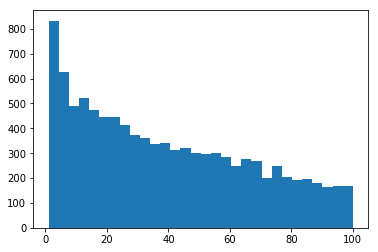

In [52]:
plt.hist(np.random.choice(XX,p=YY/np.sum(YY), size=[10000,1]), bins=30)